In [1]:
from lib import *
import pandas as pd
import matplotlib.pyplot as plt

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


#dfs = load_data_bq()
dfs = load_data_db()

df_contratos = dfs
df_contratos = df_contratos["dias_agenciados"]

Conexão estabelecida com sucesso!


In [2]:
df_eventos = pd.read_csv(
    "data/Clientes Estratégicos - B2B x Conteúdo Personalizado(base).csv", 
    sep=";", 
    encoding="latin1"  # or "cp1252"
)


df_eventos.columns = ['cnpj', 'ID', 'NOME TRANSPORTADORA(S)', 'Status', 'Tier', 'CONTROLE',
       'CONTEÚDO PERSONALIZADO', 'TELEMETRIA', 'CAVALEIRO', 'TIPO',
       'DIAS DE CONTRATO', 'Data Telemetria', 'Data Conteúdo Personalizado']


In [3]:
df_eventos = df_eventos.fillna(0)

In [4]:
import pandas as pd
import re
df = df_eventos

# Função para limpar a string e converter para lista de inteiros, ignorando itens inválidos
def parse_ids(s):
    # Remove colchetes se houver
    s_clean = re.sub(r'[\[\]]', '', s)
    result = []
    for item in s_clean.split(','):
        item_str = item.strip()
        try:
            result.append(int(item_str))
        except ValueError:
            # Ignora o item se não puder ser convertido para inteiro (ex.: '#N/D')
            continue
    return result

# Cria uma nova coluna com a lista de IDs
df['ID_list'] = df['ID'].apply(parse_ids)

# Explode a coluna 'ID_list' para transformar cada ID em uma nova linha
df_exploded = df.explode('ID_list')

# Descarta a coluna original 'ID' para evitar duplicidade
df_exploded = df_exploded.dropna(axis=0)
df_exploded = df_exploded.drop(columns=['ID'])

# Renomeia a coluna explode para "ID"
df_exploded = df_exploded.rename(columns={'ID_list': 'ID'})

# Converte a coluna de ID para inteiro (agora todos os valores são provenientes da lista)
df_exploded['ID'] = df_exploded['ID'].astype(int)



df_contratos = df_contratos.merge(df_exploded, left_on="company_id", right_on="ID")
# Converter a coluna created_at para datetime, se já não estiver no formato adequado
df_contratos['created_at'] = pd.to_datetime(df_contratos['created_at'])

# Criar as novas colunas com o mês e o ano
df_contratos['mes'] = df_contratos['created_at'].dt.month
df_contratos['ano'] = df_contratos['created_at'].dt.year
df_contratos['dia'] = df_contratos['created_at'].dt.day
# Exibe o DataFrame resultante
df_contratos.head()


,created_at,company_id,contract_days,cnpj,NOME TRANSPORTADORA(S),Status,Tier,CONTROLE,CONTEÚDO PERSONALIZADO,TELEMETRIA,CAVALEIRO,TIPO,DIAS DE CONTRATO,Data Telemetria,Data Conteúdo Personalizado,ID,mes,ano,dia
0,2023-04-28 15:50:15,423,1.0,16661925,OPERAÇÕES AMBEV,Recorrente,4,Não,Não,Não,CONSTANTINE,Cliente Estratégico,33,0,0,423,4,2023,28
1,2023-05-10 14:20:02,347,17.0,20682,TRANSPORTADORA SIDER LTDA,Recorrente,4,Não,Não,Não,CONSTANTINE,Cliente Estratégico,369,0,0,347,5,2023,10
2,2022-11-28 16:22:58,335,12.0,23850588,TRANSPANORAMA,Recorrente,2,Não,Sim,Não,GALAHAD,Cliente Estratégico,347,0,25/09/2024,335,11,2022,28
3,2022-11-28 16:37:00,159,21.0,29081265,G2L LOGISTICA,Recorrente,4,Não,Não,Sim,GALAHAD,Cliente Estratégico,1227,02/02/2024,0,159,11,2022,28
4,2022-09-28 17:33:41,249,5.0,23850588,TOZZO,Recorrente,2,Não,Sim,Sim,CONSTANTINE,Cliente Estratégico,885,21/06/2024,29/08/2024,249,9,2022,28


In [5]:
import pandas as pd

# Converter a coluna created_at para datetime
df_contratos['created_at'] = pd.to_datetime(df_contratos['created_at'])
df_contratos = df_contratos.sort_values("created_at")
# Calcular a data mínima para cada company_id
df_contratos['min_date'] = df_contratos.groupby('company_id')['created_at'].transform('min')

# Quando Data Telemetria ou Data Conteúdo Personalizado for igual a 0, transformar em NaT
df_contratos.loc[df_contratos['Data Telemetria'] == 0, 'Data Telemetria'] = np.nan
df_contratos.loc[df_contratos['Data Conteúdo Personalizado'] == 0, 'Data Conteúdo Personalizado'] = np.nan



# Calcular a diferença em dias entre created_at e a data mínima para o mesmo company_id
df_contratos['diff_days'] = (df_contratos['created_at'] - df_contratos['min_date']).dt.days
df_contratos['created_at'] = pd.to_datetime(df_contratos['created_at'], errors='coerce')
df_contratos['Data Telemetria'] = pd.to_datetime(df_contratos['Data Telemetria'], dayfirst=True, errors='coerce')
df_contratos['Data Conteúdo Personalizado'] = pd.to_datetime(df_contratos['Data Conteúdo Personalizado'], dayfirst=True, errors='coerce')

df_contratos.describe()


,created_at,company_id,contract_days,cnpj,DIAS DE CONTRATO,Data Telemetria,Data Conteúdo Personalizado,ID,mes,ano,dia,min_date,diff_days
count,142168,142168.000000,142167.000000,1.421680e+05,142168.000000,27480,29801,142168.000000,142168.000000,142168.000000,142168.000000,142168,142168.000000
mean,2024-01-30 20:49:43.652024064,1115.760607,7.253427,4.012505e+07,681.118135,2024-08-24 04:14:37.205240064,2024-10-15 00:40:38.253749504,1115.760607,6.742031,2023.561364,15.892718,2023-02-10 01:59:15.982070272,354.266509
min,2019-12-09 11:40:33,5.000000,-14.000000,0.000000e+00,-6.000000,2024-01-01 00:00:00,2024-04-17 00:00:00,5.000000,1.000000,2019.000000,1.000000,2019-12-09 11:40:33,0.000000
25%,2023-09-06 12:02:54.750000128,423.000000,1.000000,1.662217e+07,0.000000,2024-06-21 00:00:00,2024-08-29 00:00:00,423.000000,3.000000,2023.000000,8.000000,2022-08-04 08:53:28,125.000000
50%,2024-03-23 09:26:01.500000,953.000000,3.000000,2.385059e+07,60.000000,2024-09-09 00:00:00,2024-09-27 00:00:00,953.000000,7.000000,2024.000000,16.000000,2023-05-12 17:14:53,272.000000
75%,2024-09-13 14:22:38.249999872,1631.000000,9.000000,7.341033e+07,401.000000,2024-11-28 00:00:00,2025-01-10 00:00:00,1631.000000,10.000000,2024.000000,24.000000,2023-10-14 13:47:08,489.000000
max,2025-03-05 17:23:49,3916.000000,273.000000,9.840000e+07,9197.000000,2025-02-03 00:00:00,2025-03-07 00:00:00,3916.000000,12.000000,2025.000000,31.000000,2025-01-25 17:40:34,1844.000000
std,NaN,855.535671,9.831588,2.859224e+07,1808.045119,NaN,NaN,855.535671,3.639807,0.875916,8.893565,NaN,311.592476


In [6]:
df = df_contratos.copy()

In [7]:
import pandas as pd
import numpy as np

# Suponha que o DataFrame original já esteja carregado em "df"
# Exemplo: df = pd.read_csv("seu_arquivo.csv")


# =======================================================================
# Cálculo dos diff_dates em DIAS para cada grupo
# =======================================================================

# 1. Empresas sem telemetria e sem conteúdo personalizado
df['diff_date_sem_tp_sem_cp_days'] = np.where(
    (df['TELEMETRIA'] == 'Não') & (df['CONTEÚDO PERSONALIZADO'] == 'Não'),
    df['diff_days'],
    np.nan
)

# 2. Empresas com telemetria, antes da contratação 
# (primeiro log < Data Telemetria: diff = Data Telemetria - created_at)
df['diff_date_antes_tp_days'] = np.where(
    (df['TELEMETRIA'] == 'Sim') &
    (df['Data Telemetria'].notna()) &
    (df['created_at'] < df['Data Telemetria']),
    df['diff_days'],
    np.nan
)

# 3. Empresas com telemetria, após a contratação 
# (primeiro log >= Data Telemetria: diff = diff_days - (created_at - Data Telemetria))
df['diff_date_depois_tp_days'] = np.where(
    (df['TELEMETRIA'] == 'Sim') &
    (df['Data Telemetria'].notna()) &
    (df['created_at'] >= df['Data Telemetria']),
    (df['created_at'] - df['Data Telemetria']).dt.days,
    np.nan
)

# 4. Empresas com conteúdo personalizado, antes da contratação 
# (primeiro log < Data Conteúdo Personalizado: diff = Data Conteúdo Personalizado - created_at)
df['diff_date_antes_cp_days'] = np.where(
    (df['CONTEÚDO PERSONALIZADO'] == 'Sim') &
    (df['Data Conteúdo Personalizado'].notna()) &
    (df['created_at'] < df['Data Conteúdo Personalizado']),
    df['diff_days'],
    np.nan
)

# 5. Empresas com conteúdo personalizado, após a contratação 
# (primeiro log >= Data Conteúdo Personalizado: diff = diff_days - (created_at - Data Conteúdo Personalizado))
df['diff_date_depois_cp_days'] = np.where(
    (df['CONTEÚDO PERSONALIZADO'] == 'Sim') &
    (df['Data Conteúdo Personalizado'].notna()) &
    (df['created_at'] >= df['Data Conteúdo Personalizado']),
    (df['created_at'] - df['Data Conteúdo Personalizado']).dt.days,
    np.nan
)

# =======================================================================
# Conversão dos valores de dias para MESES (aproximando 30 dias por mês)
# =======================================================================
conversion_factor = 30

df['diff_date_sem_tp_sem_cp_months'] = df['diff_date_sem_tp_sem_cp_days'] / conversion_factor
df['diff_date_antes_tp_months']      = df['diff_date_antes_tp_days'] / conversion_factor
df['diff_date_depois_tp_months']       = df['diff_date_depois_tp_days'] / conversion_factor
df['diff_date_antes_cp_months']        = df['diff_date_antes_cp_days'] / conversion_factor
df['diff_date_depois_cp_months']         = df['diff_date_depois_cp_days'] / conversion_factor

# Exibe as primeiras linhas para conferir as novas colunas
cols_novas = [
    'diff_date_sem_tp_sem_cp_days', 'diff_date_sem_tp_sem_cp_months',
    'diff_date_antes_tp_days',      'diff_date_antes_tp_months',
    'diff_date_depois_tp_days',       'diff_date_depois_tp_months',
    'diff_date_antes_cp_days',        'diff_date_antes_cp_months',
    'diff_date_depois_cp_days',         'diff_date_depois_cp_months'
]
df.describe()

,created_at,company_id,contract_days,cnpj,DIAS DE CONTRATO,Data Telemetria,Data Conteúdo Personalizado,ID,mes,ano,dia,min_date,diff_days,diff_date_sem_tp_sem_cp_days,diff_date_antes_tp_days,diff_date_depois_tp_days,diff_date_antes_cp_days,diff_date_depois_cp_days,diff_date_sem_tp_sem_cp_months,diff_date_antes_tp_months,diff_date_depois_tp_months,diff_date_antes_cp_months,diff_date_depois_cp_months
count,142168,142168.000000,142167.000000,1.421680e+05,142168.000000,27480,29801,142168.000000,142168.000000,142168.000000,142168.000000,142168,142168.000000,104524.000000,16366.000000,11114.000000,22421.000000,7059.000000,104524.000000,16366.000000,11114.000000,22421.000000,7059.000000
mean,2024-01-30 20:49:43.652024064,1115.760607,7.253427,4.012505e+07,681.118135,2024-08-24 04:14:37.205240064,2024-10-15 00:40:38.253749504,1115.760607,6.742031,2023.561364,15.892718,2023-02-10 01:59:15.982070272,354.266509,293.743226,473.549126,130.070182,529.344944,88.280210,9.791441,15.784971,4.335673,17.644831,2.942674
min,2019-12-09 11:40:33,5.000000,-14.000000,0.000000e+00,-6.000000,2024-01-01 00:00:00,2024-04-17 00:00:00,5.000000,1.000000,2019.000000,1.000000,2019-12-09 11:40:33,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2023-09-06 12:02:54.750000128,423.000000,1.000000,1.662217e+07,0.000000,2024-06-21 00:00:00,2024-08-29 00:00:00,423.000000,3.000000,2023.000000,8.000000,2022-08-04 08:53:28,125.000000,108.000000,205.000000,56.000000,236.000000,37.000000,3.600000,6.833333,1.866667,7.866667,1.233333
50%,2024-03-23 09:26:01.500000,953.000000,3.000000,2.385059e+07,60.000000,2024-09-09 00:00:00,2024-09-27 00:00:00,953.000000,7.000000,2024.000000,16.000000,2023-05-12 17:14:53,272.000000,237.000000,431.500000,114.000000,493.000000,81.000000,7.900000,14.383333,3.800000,16.433333,2.700000
75%,2024-09-13 14:22:38.249999872,1631.000000,9.000000,7.341033e+07,401.000000,2024-11-28 00:00:00,2025-01-10 00:00:00,1631.000000,10.000000,2024.000000,24.000000,2023-10-14 13:47:08,489.000000,377.000000,705.000000,197.000000,783.000000,132.000000,12.566667,23.500000,6.566667,26.100000,4.400000
max,2025-03-05 17:23:49,3916.000000,273.000000,9.840000e+07,9197.000000,2025-02-03 00:00:00,2025-03-07 00:00:00,3916.000000,12.000000,2025.000000,31.000000,2025-01-25 17:40:34,1844.000000,1844.000000,1325.000000,425.000000,1440.000000,318.000000,61.466667,44.166667,14.166667,48.000000,10.600000
std,NaN,855.535671,9.831588,2.859224e+07,1808.045119,NaN,NaN,855.535671,3.639807,0.875916,8.893565,NaN,311.592476,262.742765,318.551866,91.527446,345.701329,60.899531,8.758092,10.618396,3.050915,11.523378,2.029984


In [8]:
# Grupo 1: Empresas sem telemetria e sem conteúdo personalizado
df_group1 = df[df['diff_date_sem_tp_sem_cp_days'].notna()]

# Grupo 2: Empresas com telemetria, antes da contratação 
df_group2 = df[df['diff_date_antes_tp_days'].notna()]

# Grupo 3: Empresas com telemetria, após a contratação 
df_group3 = df[df['diff_date_depois_tp_days'].notna()]

# Grupo 4: Empresas com conteúdo personalizado, antes da contratação 
df_group4 = df[df['diff_date_antes_cp_days'].notna()]

# Grupo 5: Empresas com conteúdo personalizado, após a contratação 
df_group5 = df[df['diff_date_depois_cp_days'].notna()]

# Exemplo de visualização dos dataframes
# print("Grupo 1:")
# print(df_group1.head())

# print("\nGrupo 2:")
# print(df_group2.head())

# print("\nGrupo 3:")
# print(df_group3.head())

# print("\nGrupo 4:")
# print(df_group4.head())

# print("\nGrupo 5:")
df_group5.head()


,created_at,company_id,contract_days,cnpj,NOME TRANSPORTADORA(S),Status,Tier,CONTROLE,CONTEÚDO PERSONALIZADO,TELEMETRIA,CAVALEIRO,TIPO,DIAS DE CONTRATO,Data Telemetria,Data Conteúdo Personalizado,ID,mes,ano,dia,min_date,diff_days,diff_date_sem_tp_sem_cp_days,diff_date_antes_tp_days,diff_date_depois_tp_days,diff_date_antes_cp_days,diff_date_depois_cp_days,diff_date_sem_tp_sem_cp_months,diff_date_antes_tp_months,diff_date_depois_tp_months,diff_date_antes_cp_months,diff_date_depois_cp_months
84907,2024-04-17 15:17:48,446,36.0,23850588,SELGEMAY,Recorrente,2,Não,Sim,Sim,LANCELOT,Cliente Estratégico,1417,2024-01-01,2024-04-17,446,4,2024,17,2022-07-19 15:17:25,638,NaN,NaN,107.0,NaN,0.0,NaN,NaN,3.566667,NaN,0.000000
85346,2024-04-18 10:28:02,446,30.0,23850588,SELGEMAY,Recorrente,2,Não,Sim,Sim,LANCELOT,Cliente Estratégico,1417,2024-01-01,2024-04-17,446,4,2024,18,2022-07-19 15:17:25,638,NaN,NaN,108.0,NaN,1.0,NaN,NaN,3.600000,NaN,0.033333
65238,2024-04-18 10:28:15,446,40.0,23850588,SELGEMAY,Recorrente,2,Não,Sim,Sim,LANCELOT,Cliente Estratégico,1417,2024-01-01,2024-04-17,446,4,2024,18,2022-07-19 15:17:25,638,NaN,NaN,108.0,NaN,1.0,NaN,NaN,3.600000,NaN,0.033333
65250,2024-04-18 10:28:31,446,30.0,23850588,SELGEMAY,Recorrente,2,Não,Sim,Sim,LANCELOT,Cliente Estratégico,1417,2024-01-01,2024-04-17,446,4,2024,18,2022-07-19 15:17:25,638,NaN,NaN,108.0,NaN,1.0,NaN,NaN,3.600000,NaN,0.033333
73073,2024-04-18 16:55:41,446,14.0,23850588,SELGEMAY,Recorrente,2,Não,Sim,Sim,LANCELOT,Cliente Estratégico,1417,2024-01-01,2024-04-17,446,4,2024,18,2022-07-19 15:17:25,639,NaN,NaN,108.0,NaN,1.0,NaN,NaN,3.600000,NaN,0.033333


In [9]:
import numpy as np
import pandas as pd

# Grupo 1: Empresas sem telemetria e sem conteúdo personalizado
df_group1['mes_inteiro'] = df_group1['diff_date_sem_tp_sem_cp_months'].apply(np.floor).astype(int)
group1_sum = df_group1.groupby(['company_id', 'mes_inteiro'])['contract_days'].sum().reset_index()

# Calcula a nova coluna contract_day para o Grupo 1
first_month = group1_sum[group1_sum['mes_inteiro'] == 0][['company_id', 'contract_days']].rename(
    columns={'contract_days': 'first_month_contract_days'})
group1_sum = pd.merge(group1_sum, first_month, on='company_id', how='left')
group1_mean = group1_sum.groupby('mes_inteiro')['contract_days'].mean().reset_index()


# Grupo 2: Empresas com telemetria, antes da contratação
df_group2['mes_inteiro'] = df_group2['diff_date_antes_tp_months'].apply(np.floor).astype(int)
group2_sum = df_group2.groupby(['company_id', 'mes_inteiro'])['contract_days'].sum().reset_index()

# Calcula a nova coluna contract_day para o Grupo 2
first_month = group2_sum[group2_sum['mes_inteiro'] == 0][['company_id', 'contract_days']].rename(
    columns={'contract_days': 'first_month_contract_days'})
group2_sum = pd.merge(group2_sum, first_month, on='company_id', how='left')
group2_mean = group2_sum.groupby('mes_inteiro')['contract_days'].mean().reset_index()


# Grupo 3: Empresas com telemetria, após a contratação
df_group3['mes_inteiro'] = df_group3['diff_date_depois_tp_months'].apply(np.floor).astype(int)
group3_sum = df_group3.groupby(['company_id', 'mes_inteiro'])['contract_days'].sum().reset_index()

# Calcula a nova coluna contract_day para o Grupo 3
first_month = group3_sum[group3_sum['mes_inteiro'] == 0][['company_id', 'contract_days']].rename(
    columns={'contract_days': 'first_month_contract_days'})
group3_sum = pd.merge(group3_sum, first_month, on='company_id', how='left')
group3_mean = group3_sum.groupby('mes_inteiro')['contract_days'].mean().reset_index()


# Grupo 4: Empresas com conteúdo personalizado, antes da contratação
df_group4['mes_inteiro'] = df_group4['diff_date_antes_cp_months'].apply(np.floor).astype(int)
group4_sum = df_group4.groupby(['company_id', 'mes_inteiro'])['contract_days'].sum().reset_index()

# Calcula a nova coluna contract_day para o Grupo 4
first_month = group4_sum[group4_sum['mes_inteiro'] == 0][['company_id', 'contract_days']].rename(
    columns={'contract_days': 'first_month_contract_days'})
group4_sum = pd.merge(group4_sum, first_month, on='company_id', how='left')
group4_mean = group4_sum.groupby('mes_inteiro')['contract_days'].mean().reset_index()


# Grupo 5: Empresas com conteúdo personalizado, após a contratação
df_group5['mes_inteiro'] = df_group5['diff_date_depois_cp_months'].apply(np.floor).astype(int)
group5_sum = df_group5.groupby(['company_id', 'mes_inteiro'])['contract_days'].sum().reset_index()

# Calcula a nova coluna contract_day para o Grupo 5
first_month = group5_sum[group5_sum['mes_inteiro'] == 0][['company_id', 'contract_days']].rename(
    columns={'contract_days': 'first_month_contract_days'})
group5_sum = pd.merge(group5_sum, first_month, on='company_id', how='left')
group5_mean = group5_sum.groupby('mes_inteiro')['contract_days'].mean().reset_index()


# Exibe os resultados
print("Média de contract_day por mês - Grupo 1:")
print(group1_mean)

print("\nMédia de contract_day por mês - Grupo 2:")
print(group2_mean)

print("\nMédia de contract_day por mês - Grupo 3:")
print(group3_mean)

print("\nMédia de contract_day por mês - Grupo 4:")
print(group4_mean)

print("\nMédia de contract_day por mês - Grupo 5:")
print(group5_mean)


Média de contract_day por mês - Grupo 1:
    mes_inteiro  contract_days
0             0      35.227828
1             1      42.446875
2             2      50.146168
3             3      59.545263
4             4      65.628641
5             5      62.850490
6             6      70.612299
7             7      67.124324
8             8      69.498551
9             9      74.487805
10           10      89.051447
11           11      88.717241
12           12      93.120833
13           13      92.080952
14           14      88.916230
15           15      78.144509
16           16      72.158824
17           17      69.850000
18           18      81.007463
19           19      69.746154
20           20      83.178571
21           21      74.343750
22           22      84.786517
23           23      81.512821
24           24      58.721519
25           25      55.296296
26           26      60.942029
27           27      56.903226
28           28      70.300000
29           29      69.78000

/tmp/ipykernel_61091/3730695419.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group1['mes_inteiro'] = df_group1['diff_date_sem_tp_sem_cp_months'].apply(np.floor).astype(int)
/tmp/ipykernel_61091/3730695419.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group2['mes_inteiro'] = df_group2['diff_date_antes_tp_months'].apply(np.floor).astype(int)
/tmp/ipykernel_61091/3730695419.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [10]:
group1_mean.head()

,mes_inteiro,contract_days
0,0,35.227828
1,1,42.446875
2,2,50.146168
3,3,59.545263
4,4,65.628641


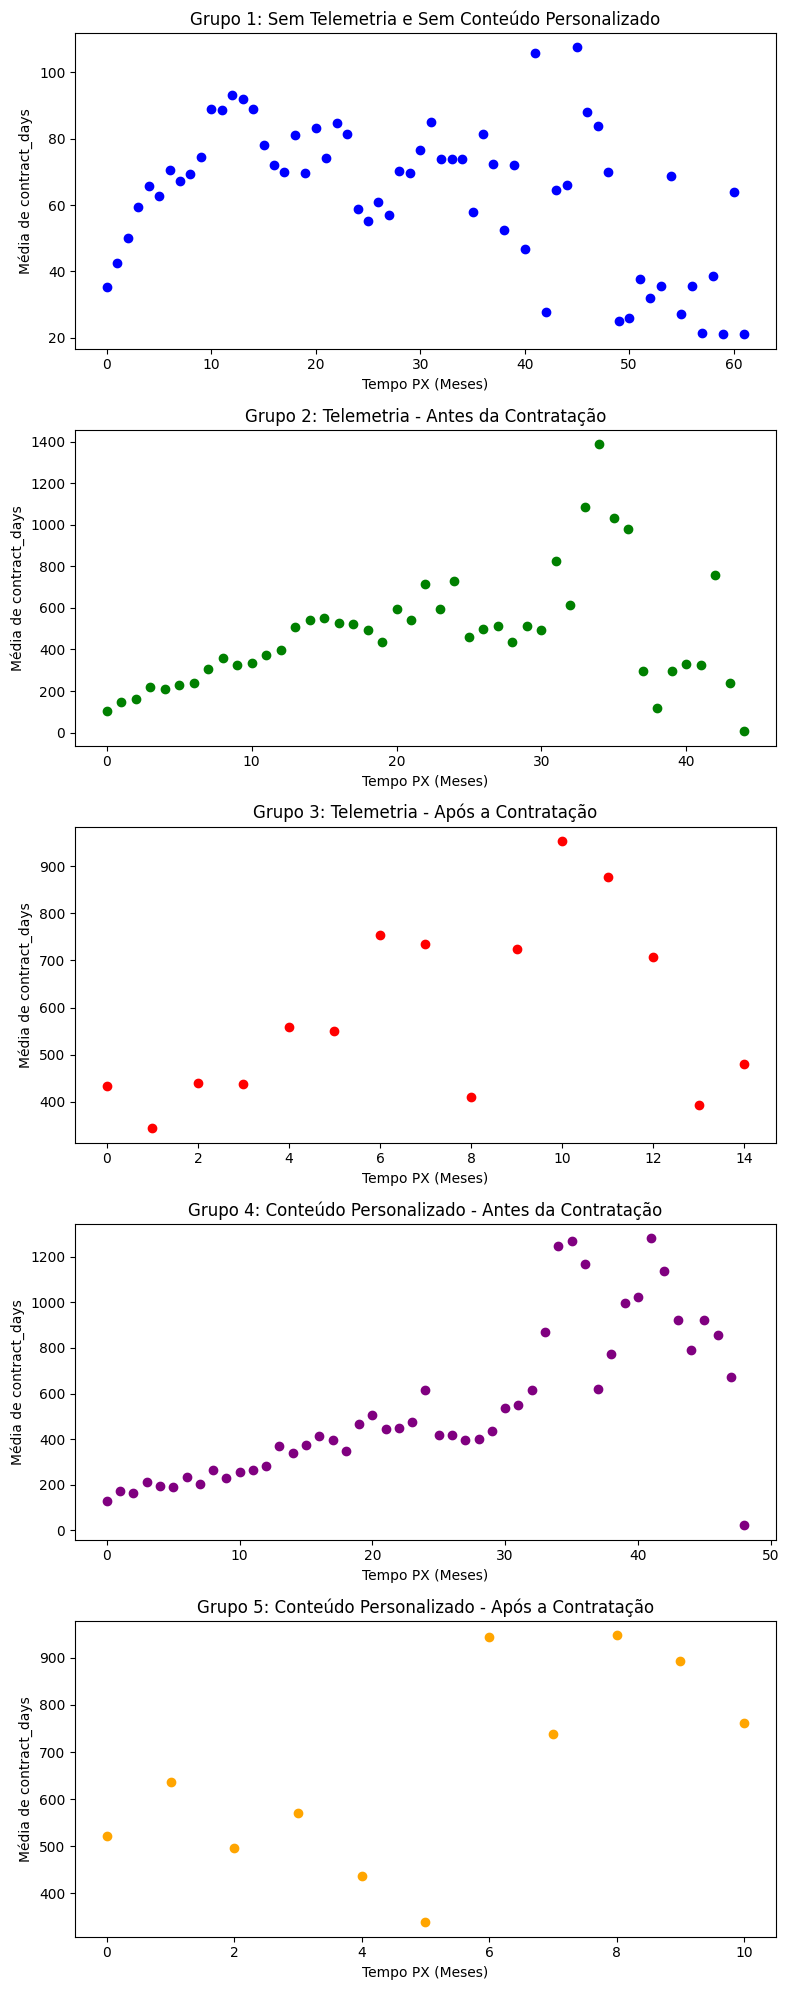

In [11]:
import matplotlib.pyplot as plt

# Cria uma figura com 5 subplots (um para cada grupo)
fig, axs = plt.subplots(5, 1, figsize=(8, 20))

# Grupo 1: Empresas sem telemetria e sem conteúdo personalizado
axs[0].scatter(group1_mean['mes_inteiro'], group1_mean['contract_days'], color='blue')
axs[0].set_title("Grupo 1: Sem Telemetria e Sem Conteúdo Personalizado")
axs[0].set_xlabel("Tempo PX (Meses)")
axs[0].set_ylabel("Média de contract_days")

# Grupo 2: Empresas com telemetria, antes da contratação 
axs[1].scatter(group2_mean['mes_inteiro'], group2_mean['contract_days'], color='green')
axs[1].set_title("Grupo 2: Telemetria - Antes da Contratação")
axs[1].set_xlabel("Tempo PX (Meses)")
axs[1].set_ylabel("Média de contract_days")

# Grupo 3: Empresas com telemetria, após a contratação 
axs[2].scatter(group3_mean['mes_inteiro'], group3_mean['contract_days'], color='red')
axs[2].set_title("Grupo 3: Telemetria - Após a Contratação")
axs[2].set_xlabel("Tempo PX (Meses)")
axs[2].set_ylabel("Média de contract_days")

# Grupo 4: Empresas com conteúdo personalizado, antes da contratação 
axs[3].scatter(group4_mean['mes_inteiro'], group4_mean['contract_days'], color='purple')
axs[3].set_title("Grupo 4: Conteúdo Personalizado - Antes da Contratação")
axs[3].set_xlabel("Tempo PX (Meses)")
axs[3].set_ylabel("Média de contract_days")

# Grupo 5: Empresas com conteúdo personalizado, após a contratação 
axs[4].scatter(group5_mean['mes_inteiro'], group5_mean['contract_days'], color='orange')
axs[4].set_title("Grupo 5: Conteúdo Personalizado - Após a Contratação")
axs[4].set_xlabel("Tempo PX (Meses)")
axs[4].set_ylabel("Média de contract_days")

plt.tight_layout()
plt.show()


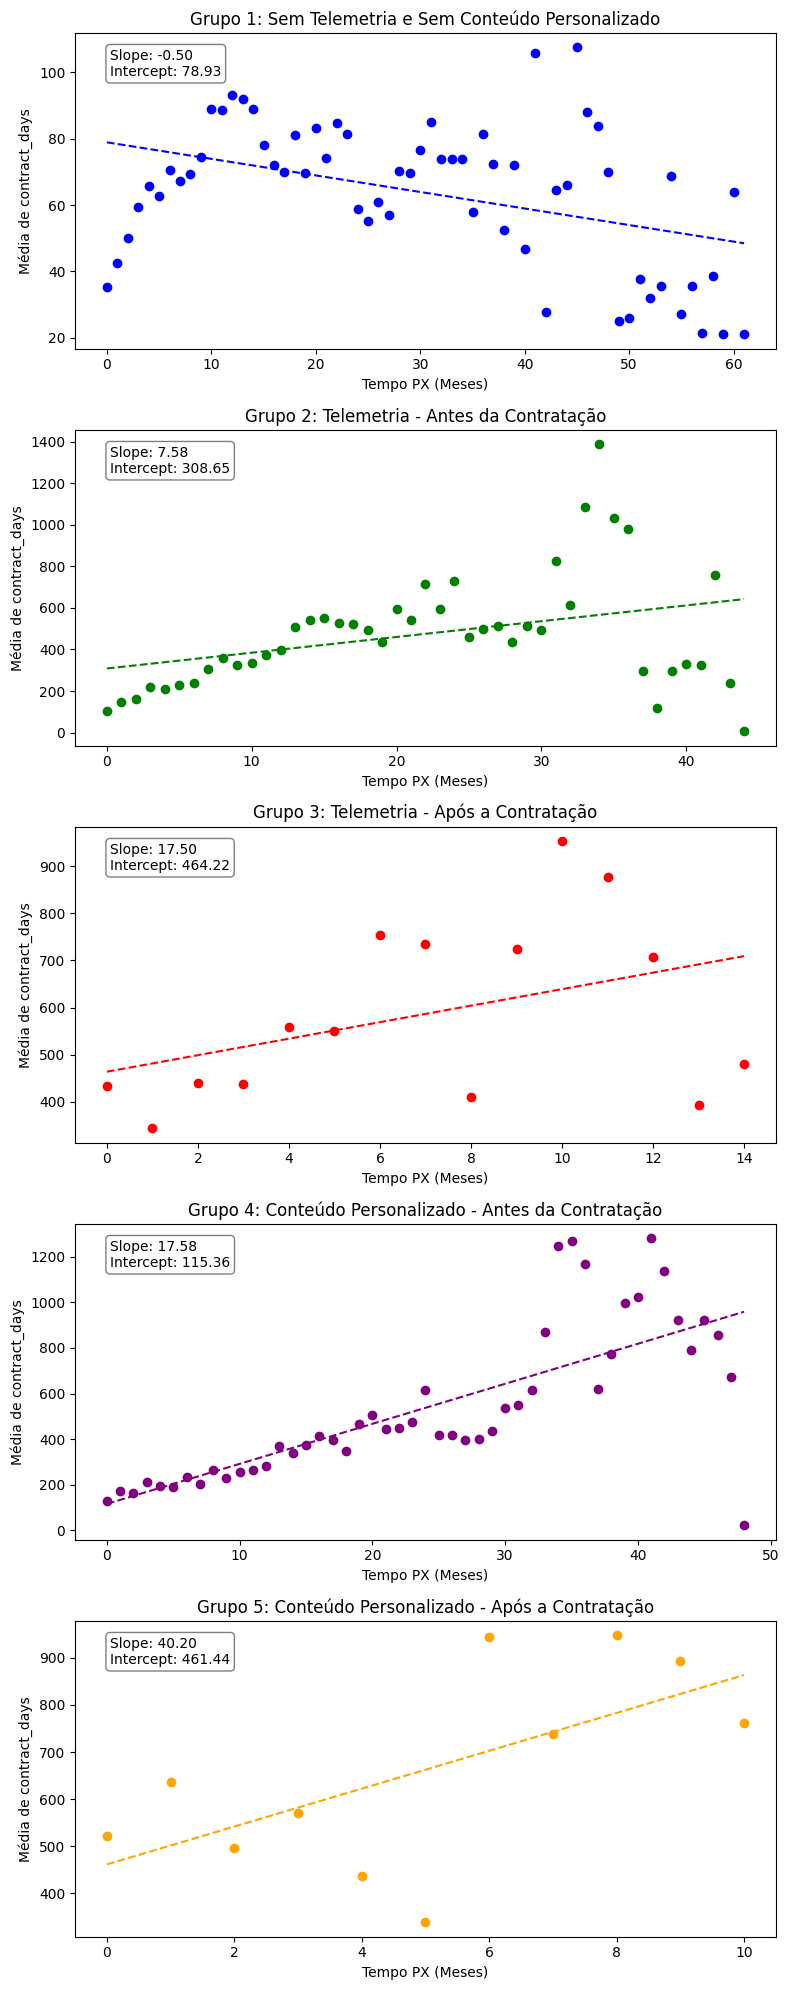

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_regression(ax, df, title, color):
    # Extrai os valores para x e y
    x = df['mes_inteiro']
    y = df['contract_days']
    
    # Plota os dados em scatter
    ax.scatter(x, y, color=color)
    
    # Calcula os parâmetros da regressão linear: slope (coeficiente angular) e intercept
    slope, intercept = np.polyfit(x, y, 1)
    
    # Gera valores para a linha de regressão
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, color=color, linestyle='--')
    
    # Anota os parâmetros da regressão no gráfico
    textstr = f"Slope: {slope:.2f}\nIntercept: {intercept:.2f}"
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # Define título e rótulos dos eixos
    ax.set_title(title)
    ax.set_xlabel("Tempo PX (Meses)")
    ax.set_ylabel("Média de contract_days")

# Cria uma figura com 5 subplots (um para cada grupo)
fig, axs = plt.subplots(5, 1, figsize=(8, 20))

# Grupo 1: Empresas sem telemetria e sem conteúdo personalizado
plot_regression(axs[0], group1_mean, "Grupo 1: Sem Telemetria e Sem Conteúdo Personalizado", 'blue')

# Grupo 2: Empresas com telemetria, antes da contratação 
plot_regression(axs[1], group2_mean, "Grupo 2: Telemetria - Antes da Contratação", 'green')

# Grupo 3: Empresas com telemetria, após a contratação 
plot_regression(axs[2], group3_mean, "Grupo 3: Telemetria - Após a Contratação", 'red')

# Grupo 4: Empresas com conteúdo personalizado, antes da contratação 
plot_regression(axs[3], group4_mean, "Grupo 4: Conteúdo Personalizado - Antes da Contratação", 'purple')

# Grupo 5: Empresas com conteúdo personalizado, após a contratação 
plot_regression(axs[4], group5_mean, "Grupo 5: Conteúdo Personalizado - Após a Contratação", 'orange')

plt.tight_layout()
plt.show()


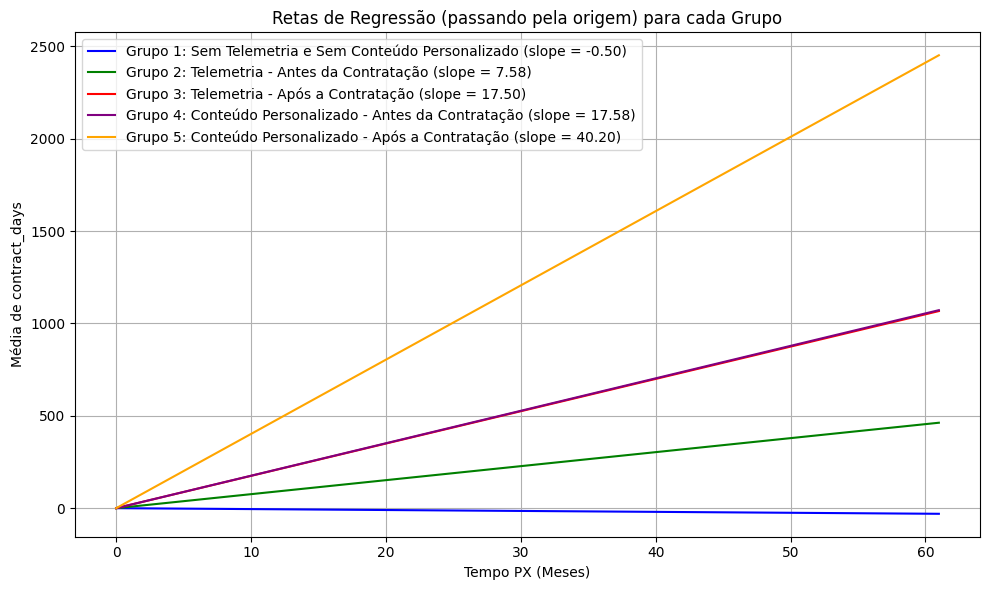

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Cria um dicionário com os DataFrames de média e as cores correspondentes para cada grupo
groups = {
    "Grupo 1: Sem Telemetria e Sem Conteúdo Personalizado": (group1_mean, 'blue'),
    "Grupo 2: Telemetria - Antes da Contratação": (group2_mean, 'green'),
    "Grupo 3: Telemetria - Após a Contratação": (group3_mean, 'red'),
    "Grupo 4: Conteúdo Personalizado - Antes da Contratação": (group4_mean, 'purple'),
    "Grupo 5: Conteúdo Personalizado - Após a Contratação": (group5_mean, 'orange')
}

# Define um intervalo comum para o eixo x, usando o valor máximo de "mes_inteiro" entre todos os grupos
all_x = []
for df, color in groups.values():
    all_x.extend(df['mes_inteiro'].tolist())
max_x = max(all_x)
x_line = np.linspace(0, max_x, 100)

# Cria o gráfico
plt.figure(figsize=(10, 6))
for group_name, (df, color) in groups.items():
    # Calcula o slope da regressão linear (ignorando o intercepto) usando np.polyfit
    slope, _ = np.polyfit(df['mes_inteiro'], df['contract_days'], 1)
    # Plota a reta que passa pela origem: y = slope * x
    plt.plot(x_line, slope * x_line, color=color,
             label=f"{group_name} (slope = {slope:.2f})")

# Configurações do gráfico
plt.title("Retas de Regressão (passando pela origem) para cada Grupo")
plt.xlabel("Tempo PX (Meses)")
plt.ylabel("Média de contract_days")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


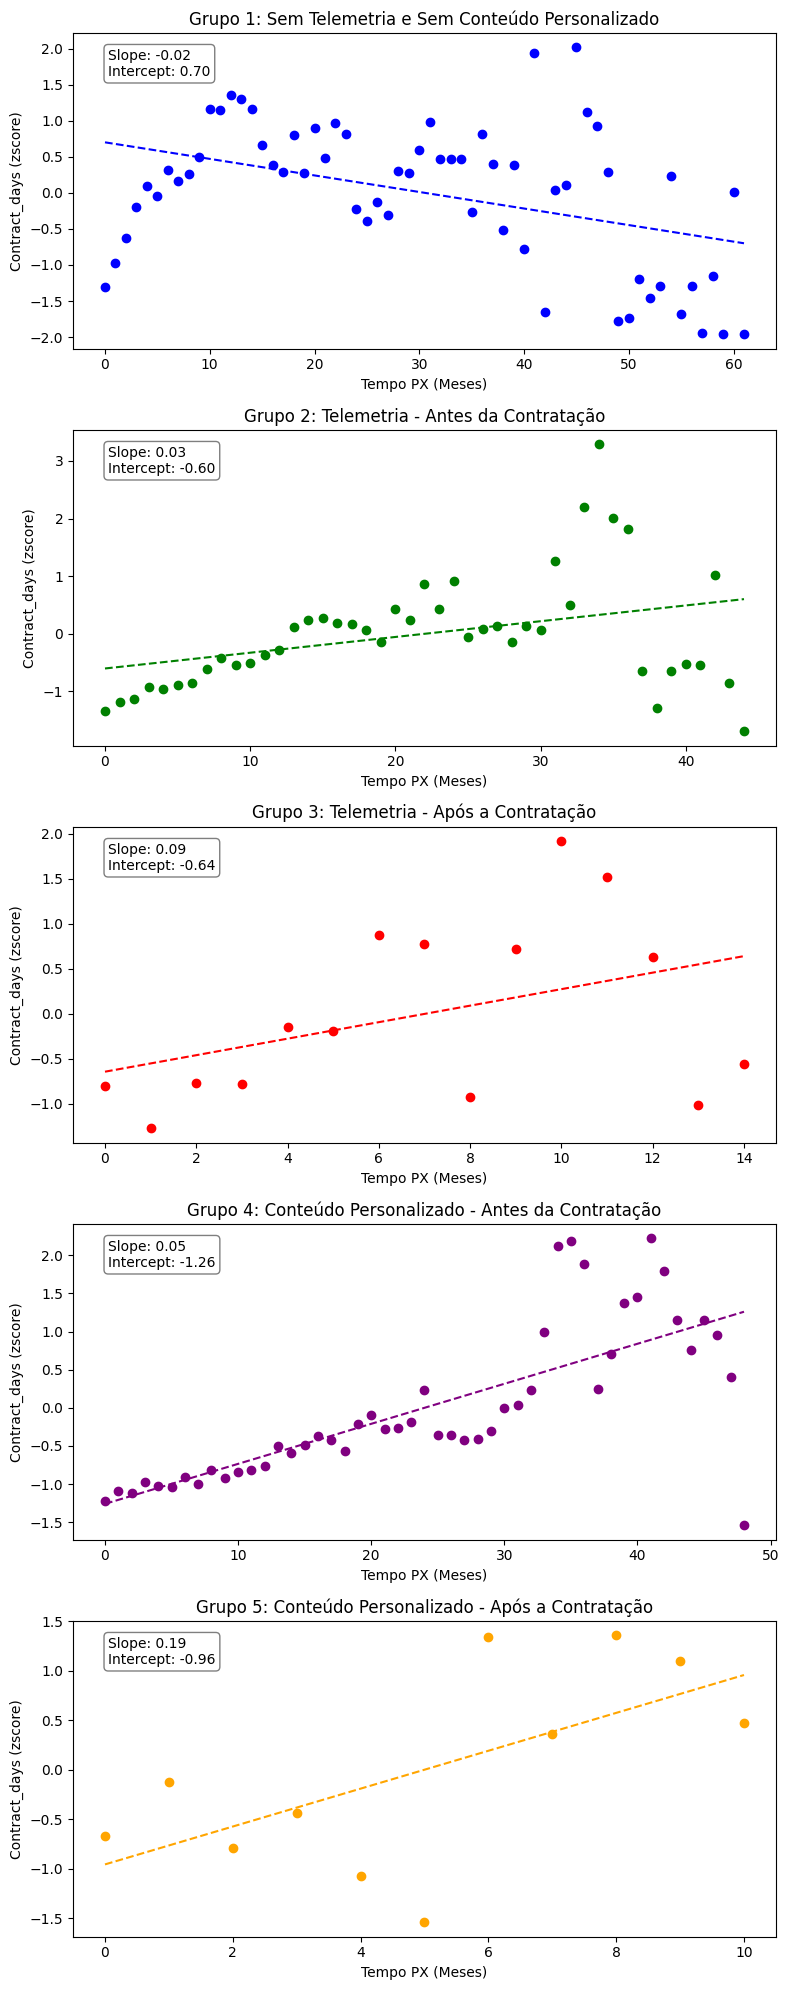

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_regression(ax, df, title, color):
    # Extrai os valores para x e y
    x = df['mes_inteiro']
    y = df['contract_days']
    
    # Aplica a normalização por zscore: (valor - média) / desvio padrão
    y_z = (y - y.mean()) / y.std()
    
    # Plota os dados normalizados (zscore) em scatter
    ax.scatter(x, y_z, color=color)
    
    # Calcula os parâmetros da regressão linear para os dados com zscore: slope e intercept
    slope, intercept = np.polyfit(x, y_z, 1)
    
    # Gera valores para a linha de regressão
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, color=color, linestyle='--')
    
    # Anota os parâmetros da regressão no gráfico
    textstr = f"Slope: {slope:.2f}\nIntercept: {intercept:.2f}"
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # Define título e rótulos dos eixos
    ax.set_title(title)
    ax.set_xlabel("Tempo PX (Meses)")
    ax.set_ylabel("Contract_days (zscore)")

# Cria uma figura com 5 subplots (um para cada grupo)
fig, axs = plt.subplots(5, 1, figsize=(8, 20))

# Grupo 1: Empresas sem telemetria e sem conteúdo personalizado
plot_regression(axs[0], group1_mean, "Grupo 1: Sem Telemetria e Sem Conteúdo Personalizado", 'blue')

# Grupo 2: Empresas com telemetria, antes da contratação 
plot_regression(axs[1], group2_mean, "Grupo 2: Telemetria - Antes da Contratação", 'green')

# Grupo 3: Empresas com telemetria, após a contratação 
plot_regression(axs[2], group3_mean, "Grupo 3: Telemetria - Após a Contratação", 'red')

# Grupo 4: Empresas com conteúdo personalizado, antes da contratação 
plot_regression(axs[3], group4_mean, "Grupo 4: Conteúdo Personalizado - Antes da Contratação", 'purple')

# Grupo 5: Empresas com conteúdo personalizado, após a contratação 
plot_regression(axs[4], group5_mean, "Grupo 5: Conteúdo Personalizado - Após a Contratação", 'orange')

plt.tight_layout()
plt.show()


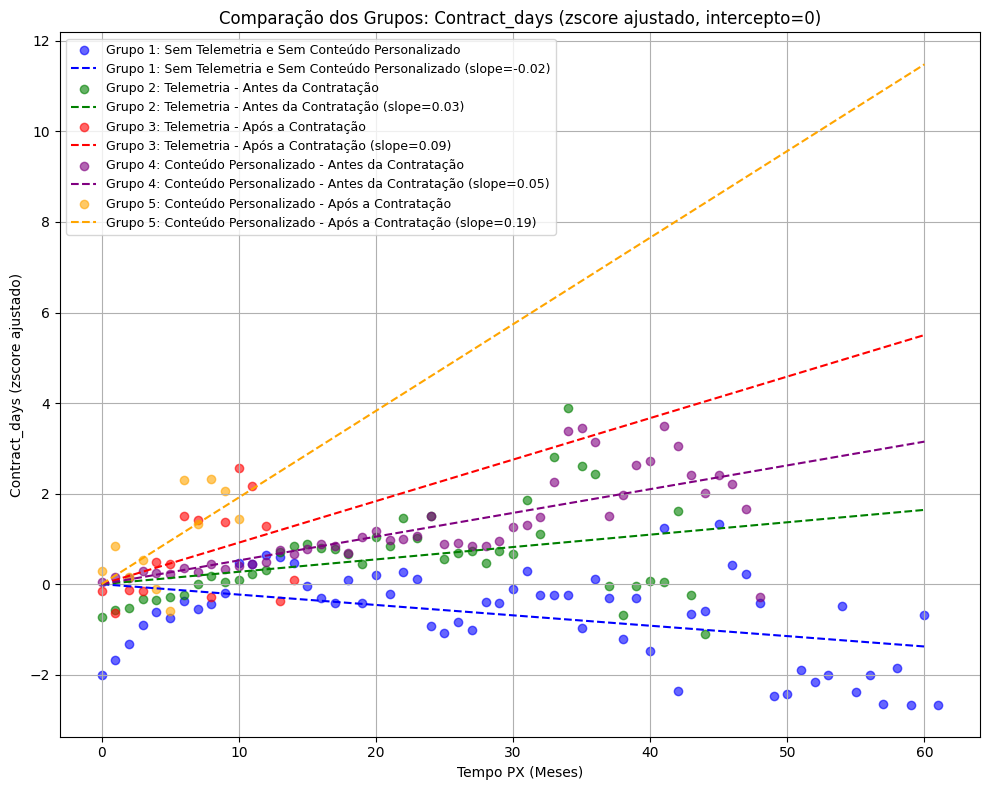

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_regression(ax, df, group_label, color):
    # Extrai os valores para x e y
    x = df['mes_inteiro']
    y = df['contract_days']
    
    # Aplica a normalização por zscore: (valor - média) / desvio padrão
    y_z = (y - y.mean()) / y.std()
    
    # Calcula os parâmetros da regressão linear para os dados com zscore: slope e intercept
    slope, intercept = np.polyfit(x, y_z, 1)
    # Ajusta os dados para que o intercepto fique zero
    y_adjusted = y_z - intercept

    # Plota os dados ajustados em scatter (com label)
    ax.scatter(x, y_adjusted, color=color, alpha=0.6, label=group_label)
    
    # Gera valores para a reta de regressão forçada a intercepto zero
    x_line = np.linspace(x.min(), 60, 100)
    y_line = slope * x_line  # intercept forçado a zero
    ax.plot(x_line, y_line, color=color, linestyle='--',
            label=f"{group_label} (slope={slope:.2f})")
    
# Cria uma figura com um único eixo para sobrepor os gráficos dos 5 grupos
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plota os 5 grupos no mesmo gráfico, com a mesma cor para pontos e reta
plot_regression(ax, group1_mean, "Grupo 1: Sem Telemetria e Sem Conteúdo Personalizado", 'blue')
plot_regression(ax, group2_mean, "Grupo 2: Telemetria - Antes da Contratação", 'green')
plot_regression(ax, group3_mean, "Grupo 3: Telemetria - Após a Contratação", 'red')
plot_regression(ax, group4_mean, "Grupo 4: Conteúdo Personalizado - Antes da Contratação", 'purple')
plot_regression(ax, group5_mean, "Grupo 5: Conteúdo Personalizado - Após a Contratação", 'orange')

# Configurações do gráfico
ax.set_title("Comparação dos Grupos: Contract_days (zscore ajustado, intercepto=0)")
ax.set_xlabel("Tempo PX (Meses)")
ax.set_ylabel("Contract_days (zscore ajustado)")
ax.grid(True)


# Para evitar entradas duplicadas na legenda (scatter e linha para o mesmo grupo),
# filtramos os rótulos duplicados
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=9)

plt.tight_layout()
plt.show()


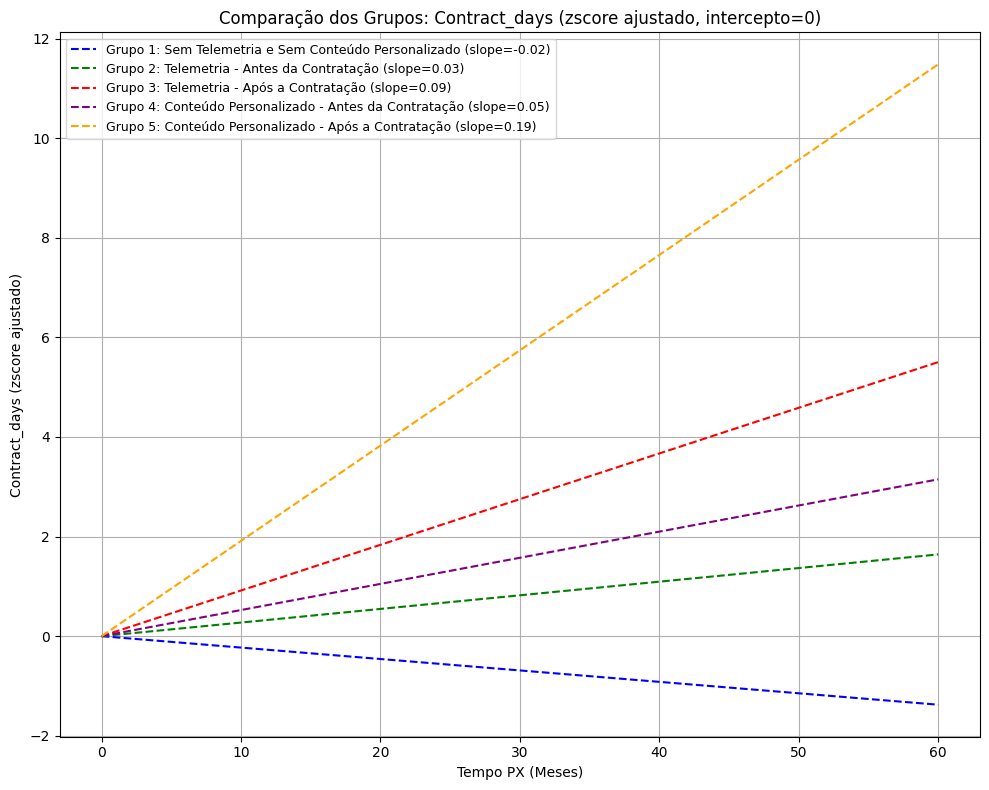

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def plot_regression(ax, df, group_label, color):
    # Extrai os valores para x e y
    x = df['mes_inteiro']
    y = df['contract_days']
    
    # Aplica a normalização por zscore: (valor - média) / desvio padrão
    y_z = (y - y.mean()) / y.std()
    
    # Calcula os parâmetros da regressão linear para os dados com zscore: slope e intercept
    slope, intercept = np.polyfit(x, y_z, 1)
    # Ajusta os dados para que o intercepto fique zero
    y_adjusted = y_z - intercept

    # Plota os dados ajustados em scatter (com label)
    # ax.scatter(x, y_adjusted, color=color, alpha=0.6, label=group_label)
    
    # Gera valores para a reta de regressão forçada a intercepto zero
    x_line = np.linspace(x.min(), 60, 100)
    y_line = slope * x_line  # intercept forçado a zero
    ax.plot(x_line, y_line, color=color, linestyle='--',
            label=f"{group_label} (slope={slope:.2f})")
    
# Cria uma figura com um único eixo para sobrepor os gráficos dos 5 grupos
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plota os 5 grupos no mesmo gráfico, com a mesma cor para pontos e reta
plot_regression(ax, group1_mean, "Grupo 1: Sem Telemetria e Sem Conteúdo Personalizado", 'blue')
plot_regression(ax, group2_mean, "Grupo 2: Telemetria - Antes da Contratação", 'green')
plot_regression(ax, group3_mean, "Grupo 3: Telemetria - Após a Contratação", 'red')
plot_regression(ax, group4_mean, "Grupo 4: Conteúdo Personalizado - Antes da Contratação", 'purple')
plot_regression(ax, group5_mean, "Grupo 5: Conteúdo Personalizado - Após a Contratação", 'orange')

# Configurações do gráfico
ax.set_title("Comparação dos Grupos: Contract_days (zscore ajustado, intercepto=0)")
ax.set_xlabel("Tempo PX (Meses)")
ax.set_ylabel("Contract_days (zscore ajustado)")
ax.grid(True)


# Para evitar entradas duplicadas na legenda (scatter e linha para o mesmo grupo),
# filtramos os rótulos duplicados
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=9)

plt.tight_layout()
plt.show()
